# Train/Test Split

In [1]:
import yaml
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
# plt.rcParams['font.serif'] = ['Times New Roman']
# import seaborn as sns; sns.set_theme()

from paperswithtopic.config import load_config
from paperswithtopic.run import setup

In [2]:
cfg = load_config()
cfg.drop = []

In [3]:
X, y, train_dl, valid_dl = setup(cfg=cfg, debug=True)

Load tokenized, without embeddings.
[load_data] 0.2 sec 
[tokenized_pipeline] 4.7 sec 


In [4]:
with open('./data/column2idx.yml', 'r') as f:
    col2idx = yaml.load(f)

<ipython-input-4-00e7e6ab330d>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  col2idx = yaml.load(f)


In [5]:
df = pd.concat([
    pd.Series(np.sum(train_dl.dataset.label, axis=0)),
    pd.Series(np.sum(valid_dl.dataset.label, axis=0)),
], axis=1).rename(columns={0: 'train', 1: 'valid'})

df /= df.sum()

In [6]:
ticks = list(col2idx.keys())[:7] + list(col2idx.keys())[8:]

In [7]:
ticks[9] = 'natural-language'

<ipython-input-8-5c06617a9f5d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, size='large')


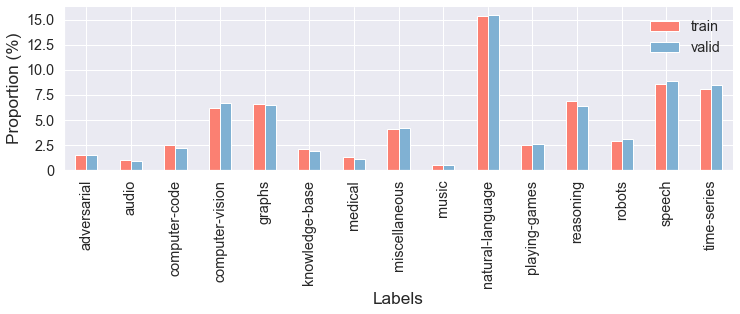

In [8]:
fig, ax = plt.subplots(figsize=(12, 3))

colors = ['#b2182b', '#2166ac']
# colors = ['#8dd3c7', '#fb8072']
# colors = ['#bf812d', '#35978f']
colors = ['#fb8072', '#80b1d3', '#8dd3c7']
df.drop(7).plot(kind='bar', ax=ax, color=colors, alpha=1)
# ax.set_title('Train/Test Label Distribution', size=18)

ax.set_xlabel('Labels', size='x-large') 
ax.set_xticklabels(ticks, size='large')
yticks = [0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0]
ax.set_yticklabels(yticks, size='large')
# ax.set_xticklabels(col2idx.keys(), size='medium')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Proportion (%)', size='x-large')
ax.legend(frameon=False, fontsize='large')
plt.savefig('fig1.png', transparent=False, facecolor='white', bbox_inches='tight')

In [9]:
import pandas as pd
df = pd.read_csv('./data/paperswithtopic.csv', index_col=0)
df[df > 1] = 1

In [10]:
(df[df['methodology'] == 1].sum(axis=1) == 1).index

Index(['Best Practices for Noise-Based Augmentation to Improve the Performance of Emotion Recognition "In the Wild"',
       'Graphfool: Targeted Label Adversarial Attack on Graph Embedding',
       'On Fast Adversarial Robustness Adaptation in Model-Agnostic Meta-Learning',
       'Adversarial Attack on Network Embeddings via Supervised Network Poisoning',
       'Stereopagnosia: Fooling Stereo Networks with Adversarial Perturbations',
       'Random Transformation of Image Brightness for Adversarial Attack',
       'Variational Quantum Cloning: Improving Practicality for Quantum Cryptanalysis',
       'FenceBox: A Platform for Defeating Adversarial Examples with Data Augmentation Techniques',
       'Dynamic backdoor attacks against federated learning',
       'Combining GANs and AutoEncoders for Efficient Anomaly Detection',
       ...
       'ChainNet: Learning on Blockchain Graphs with Topological Features',
       'Learning Semantic-Specific Graph Representation for Multi-Label I

# Valid Loss Plot

In [11]:
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("1pha/paperswithtopic")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

In [12]:
def get_runs_tags(tag):
    return list(filter(lambda x: tag in x._attrs['tags'], runs))

In [13]:
eesweep = get_runs_tags('ELECTRA CLF SWEEP')

In [14]:
eesweep

[<Run 1pha/paperswithtopic/dikag8h4 (finished)>,
 <Run 1pha/paperswithtopic/px9jjbeb (finished)>,
 <Run 1pha/paperswithtopic/wh3hulsg (finished)>,
 <Run 1pha/paperswithtopic/b70f44e6 (finished)>,
 <Run 1pha/paperswithtopic/x1vqnfif (finished)>,
 <Run 1pha/paperswithtopic/s1q0gx0g (finished)>,
 <Run 1pha/paperswithtopic/fimvdgaw (finished)>,
 <Run 1pha/paperswithtopic/xdrji3lp (finished)>,
 <Run 1pha/paperswithtopic/mhhkfq9r (finished)>,
 <Run 1pha/paperswithtopic/emfgjaya (finished)>,
 <Run 1pha/paperswithtopic/8ystevyp (finished)>,
 <Run 1pha/paperswithtopic/9bk1su4v (finished)>]

In [15]:
def organize_history(history, metric='valid_auc'):
    return [h[metric] for h in history]

In [16]:
def retrieve_features(run, feat='hidden_dim'):
    return run.config[feat]

In [17]:
eesweep_hidden_dim = list(map(retrieve_features, eesweep))

In [18]:
eesweep_hidden_dim

[512, 512, 512, 512, 256, 256, 256, 256, 128, 128, 128, 128]

In [19]:
eesweep[0].config['hidden_dim']

512

In [20]:
word2vec_valauc = list(map(lambda x: organize_history(x._full_history(), metric='valid_loss'),
                           eesweep))

In [21]:
word2vec_valauc_pad = [lst + [np.nan]*(100 - len(lst)) for lst in word2vec_valauc if len(lst) < 100]

In [22]:
ee_df = pd.DataFrame(word2vec_valauc_pad)

In [23]:
ee_df['hidden_dim'] = eesweep_hidden_dim

In [35]:
def plot_std(groupby, dim, ax, color):
    mean = groupby.mean().T.loc[:, dim]
    ax.plot(mean, label=dim, color=color, linewidth=2)
    ax.fill_between(
        list(mean.index),
        mean + groupby.std().T.loc[:, dim],
        mean - groupby.std().T.loc[:, dim],
        alpha=0.3, color=color
    )

colormap
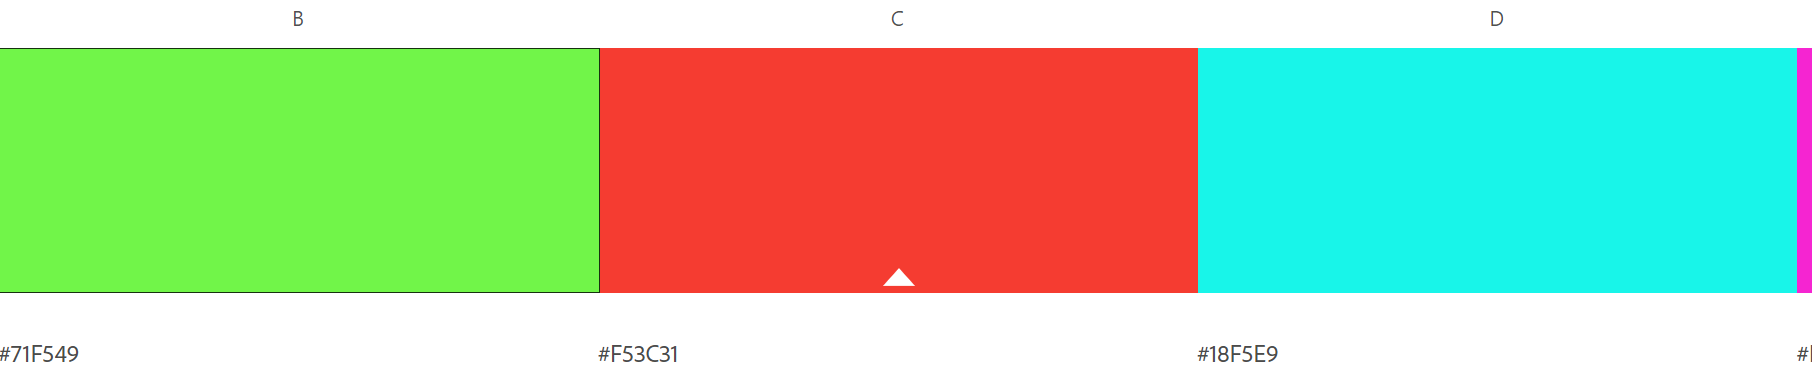
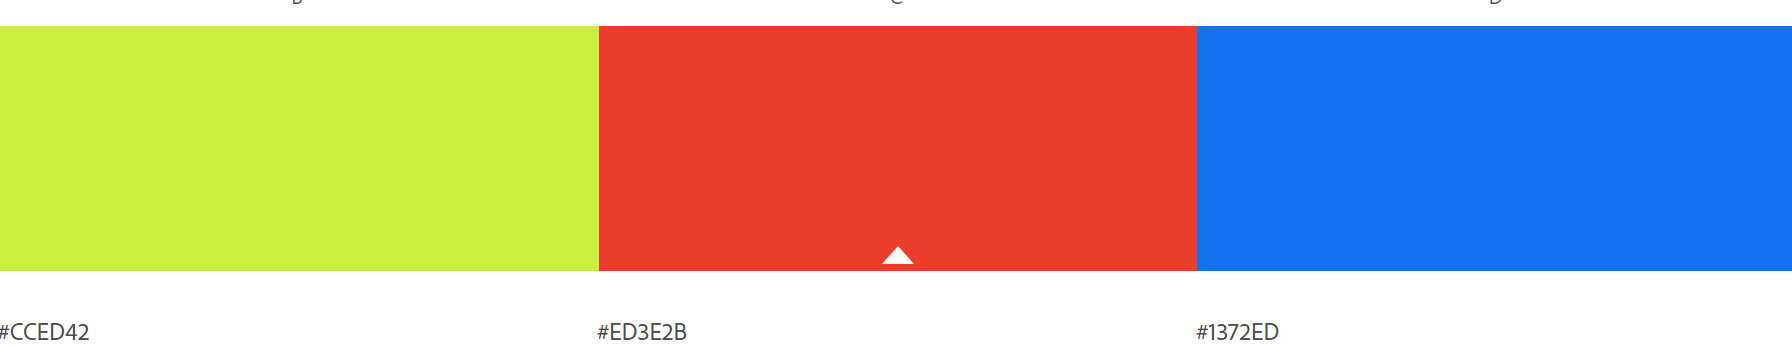
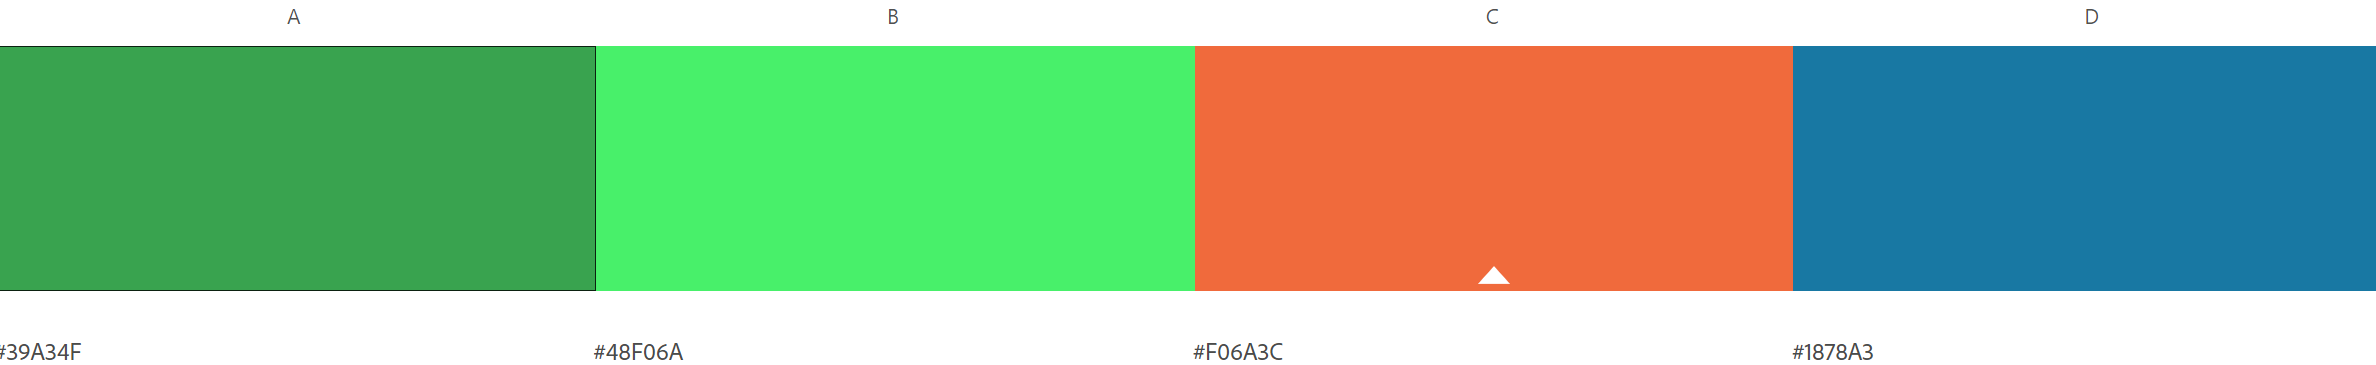
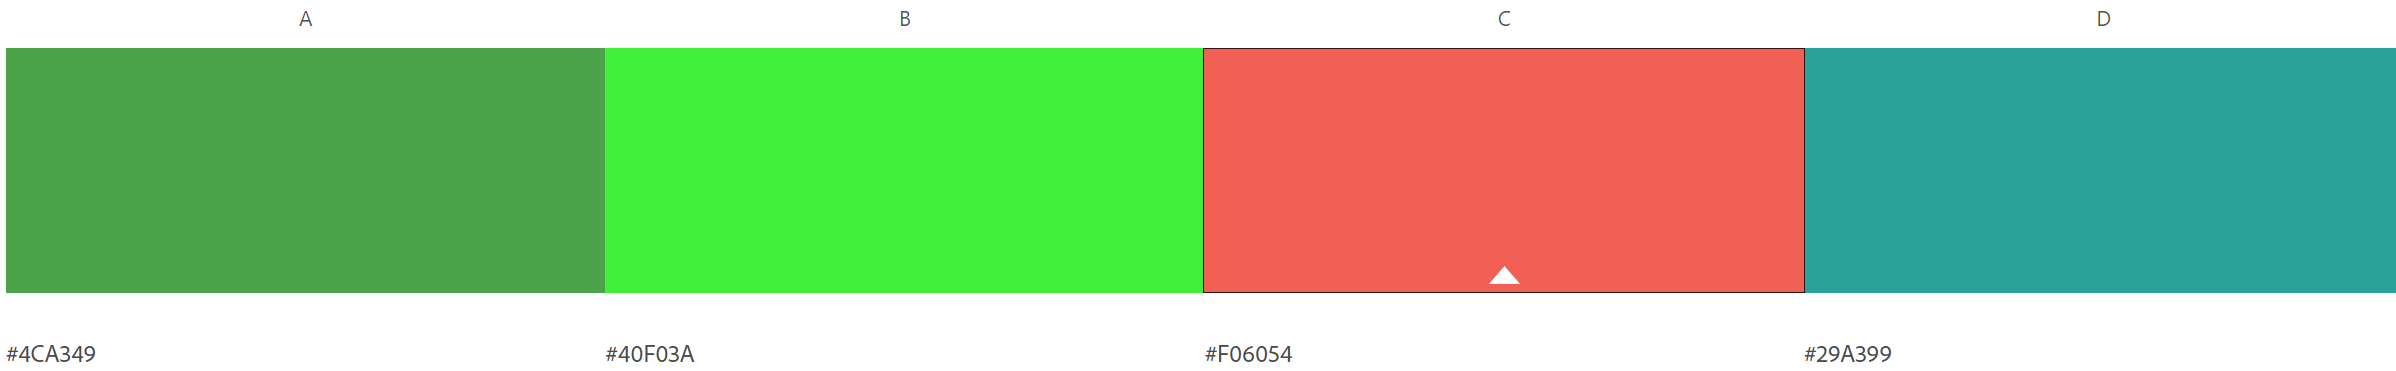

<ipython-input-38-a2ea9fb168e6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, size='large')
<ipython-input-38-a2ea9fb168e6>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, size='large')


<Figure size 432x288 with 0 Axes>

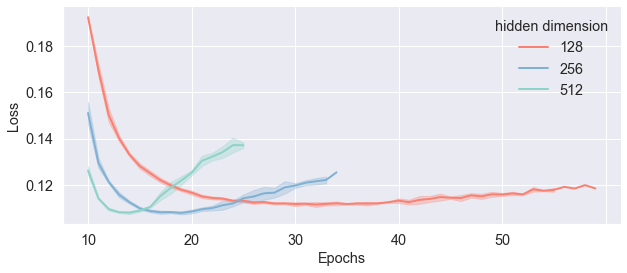

In [38]:
cmap = plt.cm.Reds
plt.set_cmap(cmap)

fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#FA732D', '#DE4C28', '#F54238']
colors = ['#71F549', '#F53C31', '#18F5E9']
colors = ['#CCED42', '#ED3E2B', '#1372ED']
colors = ['#39A34F', '#F06A3C', '#1878A3']
colors = ['#4CA349', '#29A399', '#F06054']
colors = ['red', 'green', 'blue']
colors = ['#e41a1c', '#4daf4a', '#377eb8']
colors = ['#fb8072', '#80b1d3', '#8dd3c7']
gb = ee_df.groupby('hidden_dim')
for hid, color in zip([128, 256, 512], colors):
    plot_std(gb, hid, ax, color)
# ax.set_title('Valid Loss with Hidden Dimension', size='xx-large')
ax.set_xlabel('Epochs', size='large') 

xticks = [0, 10, 20, 30, 40, 50]
ax.set_xticklabels(xticks, size='large')
yticks = [0, .12, .14, .16, .18]
ax.set_yticklabels(yticks, size='large')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Loss', size='large')
ax.legend(frameon=False, fontsize='large', title='hidden dimension', title_fontsize='large')
plt.savefig('fig2.png', transparent=False, facecolor='white', bbox_inches='tight')